In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm #para poder ver las barritas de % cargandose cuando va iterando
from PIL import Image as im

#PyTorch
import torch
import torchvision
import torchvision.transforms as transforms

from torch.utils.data import TensorDataset, DataLoader, random_split

import torch.nn as nn
import torch.nn.functional as F

#Confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sn

#Optuna
import optuna
from optuna.integration import PyTorchLightningPruningCallback

In [2]:
#Para usar solo 24 cores que me dijo NW

torch.set_num_threads(24)

In [3]:
# Function to save the model 
def saveModel(model): 
    path = "./Modelos_Fiteados/CLASIF/RES_5_T.pth" 
    torch.save(model.state_dict(), path)

## DATASET

In [3]:
#Bajo el MNIST
datatrain = torchvision.datasets.MNIST('./', train=True, download=True)
datatest = torchvision.datasets.MNIST('./', train=False, download=True)

m=len(datatrain)

train_data, val_data = random_split(datatrain, [int(m-m*0.2), int(m*0.2)])

#Lo guardo en listas en vez de tensores
X_train = [x[0] for x in train_data]
y_train = [x[1] for x in train_data]

X_val = [x[0] for x in val_data]
y_val = [x[1] for x in val_data]

X_test = [x[0] for x in datatest]
y_test = [x[1] for x in datatest]

In [4]:
keep =[0,1,2,3,4,5,6,7,8,9]

ls_train = [X_train[i] for i in range(len(X_train)) if y_train[i] in keep]
RX_train = [0]*(20*len(ls_train))
RY_train = [0]*(20*len(ls_train))

ls_val = [X_val[i] for i in range(len(X_val)) if y_val[i] in keep]
RX_val = [0]*(20*len(ls_val))
RY_val = [0]*(20*len(ls_val))

ls_test = [X_test[i] for i in range(len(X_test)) if y_test[i] in keep]
RX_test = [0]*(20*len(ls_test))
RY_test = [0]*(20*len(ls_test))

In [5]:
rotador = torchvision.transforms.functional.rotate

### Creo las imagenes rotadas

Para 3

In [ ]:
for i in range(len(ls_train)):
    for j in range(20):
        ang = np.random.randint(-60,60)
        RX_train[i*20+j]=rotador(ls_train[i],ang)
        if -60<=ang<-20:
            RY_train[i*20+j]=0
        elif -20<=ang<20:
            RY_train[i*20+j]=1
        else:
            RY_train[i*20+j]=2
            
for i in range(len(ls_val)):
    for j in range(20):
        ang = np.random.randint(-60,60)
        RX_val[i*20+j]=rotador(ls_val[i],ang)
        if -60<=ang<-20:
            RY_val[i*20+j]=0
        elif -20<=ang<20:
            RY_val[i*20+j]=1
        else:
            RY_val[i*20+j]=2
        
        
for i in range(len(ls_test)):
    for j in range(20):
        ang = np.random.randint(-60,60)
        RX_test[i*20+j]=rotador(ls_test[i],ang)
        if -60<=ang<-20:
            RY_test[i*20+j]=0
        elif -20<=ang<20:
            RY_test[i*20+j]=1
        else:
            RY_test[i*20+j]=2

Para 5

In [6]:
for i in range(len(ls_train)):
    for j in range(20):
        ang = np.random.randint(-60,60)
        RX_train[i*20+j]=rotador(ls_train[i],ang)
        if -60<=ang<-36:
            RY_train[i*20+j]=0
        elif -36<=ang<-12:
            RY_train[i*20+j]=1
        elif -12<=ang<12:
            RY_train[i*20+j]=2
        elif 12<=ang<36:
            RY_train[i*20+j]=3
        else:
            RY_train[i*20+j]=4
            
for i in range(len(ls_val)):
    for j in range(20):
        ang = np.random.randint(-60,60)
        RX_val[i*20+j]=rotador(ls_val[i],ang)
        if -60<=ang<-36:
            RY_val[i*20+j]=0
        elif -36<=ang<-12:
            RY_val[i*20+j]=1
        elif -12<=ang<12:
            RY_val[i*20+j]=2
        elif 12<=ang<36:
            RY_val[i*20+j]=3
        else:
            RY_val[i*20+j]=4
        
        
for i in range(len(ls_test)):
    for j in range(20):
        ang = np.random.randint(-60,60)
        RX_test[i*20+j]=rotador(ls_test[i],ang)
        if -60<=ang<-36:
            RY_test[i*20+j]=0
        elif -36<=ang<-12:
            RY_test[i*20+j]=1
        elif -12<=ang<12:
            RY_test[i*20+j]=2
        elif 12<=ang<36:
            RY_test[i*20+j]=3
        else:
            RY_test[i*20+j]=4

In [7]:
print('train:',len(RX_train))
print('val:',len(RX_val))

print('test:',len(RX_test))

train: 960000
val: 240000
test: 200000


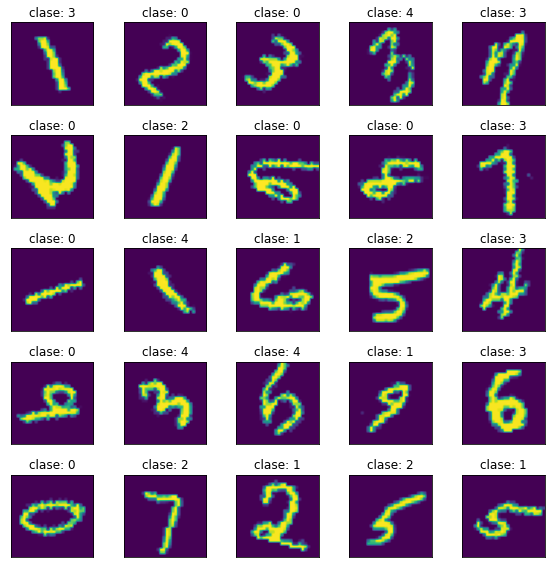

In [8]:
# Plot some samples
fig, axs = plt.subplots(5, 5, figsize=(8,8))
i = 0
for ax in axs.flatten():
    ax.imshow(np.array(RX_train[i]))
    ax.set_title(f'clase: {RY_train[i]}')
    ax.set_xticks([])
    ax.set_yticks([])
    i +=186
#plt.savefig('./Modelos_Fiteados/Imagenes/ej_todos.png', format='png')
plt.tight_layout()

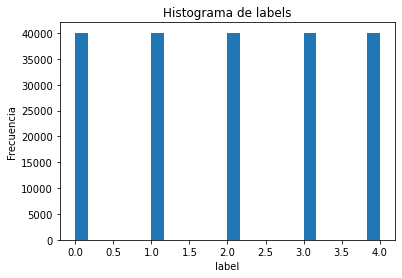

In [9]:
#Veamos si estan masomenos distribuidos
plt.hist(RY_test,24)
plt.title('Histograma de labels')
plt.xlabel('label')
plt.ylabel('Frecuencia')

plt.show() #dibujamos el histograma

#### Creo los dataloader

In [10]:
to_tensor = torchvision.transforms.ToTensor()

#####

tensor_RX_train = [to_tensor(RX_train[i]).unsqueeze(0) for i in range(len(RX_train))]
tensor_RX_train = torch.cat(tensor_RX_train)

tensor_RY_train = torch.Tensor(RY_train).long()

###

tensor_RX_val = [to_tensor(RX_val[i]).unsqueeze(0) for i in range(len(RX_val))]
tensor_RX_val = torch.cat(tensor_RX_val)

tensor_RY_val = torch.Tensor(RY_val).long()

###

tensor_RX_test = [to_tensor(RX_test[i]).unsqueeze(0) for i in range(len(RX_test))]
tensor_RX_test = torch.cat(tensor_RX_test)

tensor_RY_test = torch.Tensor(RY_test).long()

#####

tensor_datatrain = TensorDataset(tensor_RX_train, tensor_RY_train)
train_loader = DataLoader(tensor_datatrain, batch_size=10000, shuffle=True)

tensor_dataval = TensorDataset(tensor_RX_val, tensor_RY_val)
valid_loader = DataLoader(tensor_dataval, batch_size=10000, shuffle=True)

tensor_datatest = TensorDataset(tensor_RX_test, tensor_RY_test)
test_loader = DataLoader(tensor_datatest, batch_size=1)

## RED

In [11]:
class Net(nn.Module):
    def __init__(self,nf):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, nf, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(nf, nf, 3)
        self.fc1 = nn.Linear(nf*12*12, 128)
        self.fc2 = nn.Linear(128, 5)                          #ACA 3 o 5 !!! 
        self.drop = nn.Dropout(0.25)
        self.soft = nn.Softmax()

#     def forward(self, x, mode):
#         if (mode == "Train"):
#             self.train()
#         elif (mode == "Test"):
#             self.eval()

    def forward(self,x):
        # Apply net
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.drop(x)
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = self.drop(x)
        x = self.fc2(x)        
        return x

In [12]:
nf = 64
REG = Net(nf)

#Definimos la loss function
loss_fn = nn.CrossEntropyLoss()
# Definimos el optimizador
optimizer = torch.optim.Adam(REG.parameters(), lr=0.001, weight_decay=0.0001)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

#Send model to device
REG.to(device)

Selected device: cpu


Net(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=5, bias=True)
  (drop): Dropout(p=0.25, inplace=False)
  (soft): Softmax(dim=None)
)

In [13]:
### Training function
def train_epoch(REG, device, dataloader, loss_fn, optimizer):
    # Train
    REG.train()
    train_loss = []
    for data, label in dataloader:
        # Move data to device
        data = data.to(device)
        label = label.to(device)
        # process
        processed = REG.forward(data)#[:,0]
        # Compute loss
        loss = loss_fn(processed, label)
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        ###
        train_loss.append(loss.detach().cpu().numpy())
        
    return np.mean(train_loss)

In [14]:
### Testing function
def test_epoch(REG, device, dataloader, loss_fn):
    REG.eval()
    with torch.no_grad():
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for image_batch, label in dataloader:
            # Move tensor to the proper device
            image_batch = image_batch.to(device)
            # output
            decoded_data = REG.forward(image_batch)
            # Append the network output and the original image to the lists
            conc_out.append(decoded_data.cpu())
            conc_label.append(label.cpu())
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data


#         for data, label in dataloader:
#             # Move data to device
#             data = data.to(device)
#             label = label.to(device)
#             # process
#             processed = REG.forward(data)#[:,0]
#             # Compute loss
#             loss = loss_fn(processed, label)
#             #Save test loss for this batch
#             loss_batch = loss.detach().cpu().numpy()
#             test_loss.append(loss_batch)
#             #Save the average train loss
#             test_loss = np.mean(test_loss)
            
#         return test_loss

In [ ]:
#     def training_cycle(self, device, training_data, test_data, loss_fn, optim, num_epochs,
#                        keep_model=False, verbose= True):
#         """
#         This function train the network for a desired number of epochs it also test the network 
#         reconstruction performance and make plots comparing the input image and the reconstructed one 
#         every 5 epochs.
#         """
            
#         #I keep track of losses for plots
#         train_loss_1 = []
#         train_loss_2 = []
#         test_loss  = []
#         i = 0

#         for epoch in tqdm(range(num_epochs)):
#             if verbose: print('EPOCH %d/%d' % (epoch + 1, num_epochs))
#             ### Training (use the training function)
#             tr_l = self.train_epoch(device = device,
#                                     dataloader = training_data,
#                                     loss_fn = loss_fn,
#                                     optimizer = optim,
#                                     verbose = verbose)
#             train_loss_1.append(tr_l)
#             ### training_2  (use the training for loss)
#             t_l = self.test_epoch(device=device,
#                                   dataloader=training_data,
#                                   loss_fn=loss_fn,
#                                   verbose = verbose)
#             train_loss_2.append(t_l)
#             ### Validation  (use the testing function)
#             t_l = self.test_epoch(device = device,
#                                   dataloader = test_data,
#                                   loss_fn = loss_fn,
#                                   verbose = verbose)
#             test_loss.append(t_l)

#         return diz_loss['train_loss_1'], diz_loss['train_loss_2'], diz_loss['val_loss']
# # train_loss_1, train_loss_2, test_loss

### Entrenamos la red

In [15]:
num_epochs = 30
diz_loss = {'train_loss_1':[], 'train_loss_2':[], 'val_loss':[]}
for epoch in tqdm(range(num_epochs)):
    train_loss_1 =train_epoch(REG,
                              device,
                              train_loader,
                              loss_fn,
                              optimizer)
    train_loss_2 = test_epoch(REG,
                              device,
                              train_loader,
                              loss_fn)
    val_loss = test_epoch(REG,
                          device,
                          valid_loader,
                          loss_fn)
    print('\n EPOCH {}/{} \t train loss_1 {} \t train loss_2 {} \t val loss {}'.format(epoch + 1, num_epochs,train_loss_1,train_loss_2,val_loss))
    diz_loss['train_loss_1'].append(train_loss_1)
    diz_loss['train_loss_2'].append(train_loss_2)
    diz_loss['val_loss'].append(val_loss)

  3%|██▌                                                                           | 1/30 [05:03<2:26:28, 303.05s/it]


 EPOCH 1/30 	 train loss_1 0.7356039881706238 	 train loss_2 0.3266453444957733 	 val loss 0.3303384780883789


  7%|█████▏                                                                        | 2/30 [10:06<2:21:29, 303.19s/it]


 EPOCH 2/30 	 train loss_1 0.2825041711330414 	 train loss_2 0.1684567928314209 	 val loss 0.17327672243118286


 10%|███████▊                                                                      | 3/30 [15:09<2:16:19, 302.96s/it]


 EPOCH 3/30 	 train loss_1 0.18789319694042206 	 train loss_2 0.11078507453203201 	 val loss 0.11650461703538895


 13%|██████████▍                                                                   | 4/30 [20:11<2:11:12, 302.79s/it]


 EPOCH 4/30 	 train loss_1 0.14639103412628174 	 train loss_2 0.0884573757648468 	 val loss 0.09464284032583237


 17%|█████████████                                                                 | 5/30 [25:14<2:06:06, 302.67s/it]


 EPOCH 5/30 	 train loss_1 0.11836019903421402 	 train loss_2 0.06558416783809662 	 val loss 0.07175479829311371


 20%|███████████████▌                                                              | 6/30 [30:16<2:01:01, 302.57s/it]


 EPOCH 6/30 	 train loss_1 0.10128384083509445 	 train loss_2 0.05526469647884369 	 val loss 0.06186104193329811


 23%|██████████████████▏                                                           | 7/30 [35:18<1:55:58, 302.53s/it]


 EPOCH 7/30 	 train loss_1 0.08740230649709702 	 train loss_2 0.045428477227687836 	 val loss 0.052320223301649094


 27%|████████████████████▊                                                         | 8/30 [40:44<1:53:34, 309.77s/it]


 EPOCH 8/30 	 train loss_1 0.07741507142782211 	 train loss_2 0.04025042802095413 	 val loss 0.04768669605255127


 30%|███████████████████████▍                                                      | 9/30 [48:18<2:04:15, 355.01s/it]


 EPOCH 9/30 	 train loss_1 0.06923259049654007 	 train loss_2 0.032736677676439285 	 val loss 0.040245141834020615


 33%|█████████████████████████▋                                                   | 10/30 [55:46<2:07:56, 383.83s/it]


 EPOCH 10/30 	 train loss_1 0.06474661827087402 	 train loss_2 0.0292486771941185 	 val loss 0.03658441826701164


 37%|███████████████████████████▍                                               | 11/30 [1:03:16<2:07:57, 404.07s/it]


 EPOCH 11/30 	 train loss_1 0.057323675602674484 	 train loss_2 0.026940030977129936 	 val loss 0.03440307453274727


 40%|██████████████████████████████                                             | 12/30 [1:10:42<2:05:02, 416.81s/it]


 EPOCH 12/30 	 train loss_1 0.052545588463544846 	 train loss_2 0.02345483936369419 	 val loss 0.03130672127008438


 43%|████████████████████████████████▌                                          | 13/30 [1:18:09<2:00:40, 425.91s/it]


 EPOCH 13/30 	 train loss_1 0.04925797879695892 	 train loss_2 0.020393893122673035 	 val loss 0.02809586189687252


 47%|███████████████████████████████████                                        | 14/30 [1:25:40<1:55:36, 433.51s/it]


 EPOCH 14/30 	 train loss_1 0.04529058560729027 	 train loss_2 0.02090207114815712 	 val loss 0.028854699805378914


 50%|█████████████████████████████████████▌                                     | 15/30 [1:33:08<1:49:27, 437.80s/it]


 EPOCH 15/30 	 train loss_1 0.042290303856134415 	 train loss_2 0.01793086528778076 	 val loss 0.026102786883711815


 53%|████████████████████████████████████████                                   | 16/30 [1:40:37<1:42:56, 441.16s/it]


 EPOCH 16/30 	 train loss_1 0.040391501039266586 	 train loss_2 0.015623598359525204 	 val loss 0.023321060463786125


 57%|██████████████████████████████████████████▌                                | 17/30 [1:48:06<1:36:07, 443.62s/it]


 EPOCH 17/30 	 train loss_1 0.03802652284502983 	 train loss_2 0.01521373726427555 	 val loss 0.02311534434556961


 60%|█████████████████████████████████████████████                              | 18/30 [1:55:35<1:29:02, 445.24s/it]


 EPOCH 18/30 	 train loss_1 0.03471209481358528 	 train loss_2 0.012133964337408543 	 val loss 0.02036578580737114


 63%|███████████████████████████████████████████████▌                           | 19/30 [2:03:06<1:21:56, 446.94s/it]


 EPOCH 19/30 	 train loss_1 0.03400878608226776 	 train loss_2 0.011754186823964119 	 val loss 0.01981395296752453


 67%|██████████████████████████████████████████████████                         | 20/30 [2:10:36<1:14:37, 447.79s/it]


 EPOCH 20/30 	 train loss_1 0.031982291489839554 	 train loss_2 0.011660339310765266 	 val loss 0.01977529563009739


 70%|████████████████████████████████████████████████████▌                      | 21/30 [2:18:05<1:07:12, 448.07s/it]


 EPOCH 21/30 	 train loss_1 0.031093798577785492 	 train loss_2 0.011390718631446362 	 val loss 0.019742321223020554


 73%|████████████████████████████████████████████████████████▍                    | 22/30 [2:25:34<59:47, 448.47s/it]


 EPOCH 22/30 	 train loss_1 0.028681045398116112 	 train loss_2 0.009771146811544895 	 val loss 0.0175767969340086


 77%|███████████████████████████████████████████████████████████                  | 23/30 [2:33:01<52:16, 448.07s/it]


 EPOCH 23/30 	 train loss_1 0.027309825643897057 	 train loss_2 0.008780306205153465 	 val loss 0.01672273501753807


 80%|█████████████████████████████████████████████████████████████▌               | 24/30 [2:40:28<44:46, 447.69s/it]


 EPOCH 24/30 	 train loss_1 0.02676517702639103 	 train loss_2 0.008427917957305908 	 val loss 0.01623832806944847


 83%|████████████████████████████████████████████████████████████████▏            | 25/30 [2:48:00<37:24, 448.95s/it]


 EPOCH 25/30 	 train loss_1 0.02514161914587021 	 train loss_2 0.008446105755865574 	 val loss 0.016099127009510994


 87%|██████████████████████████████████████████████████████████████████▋          | 26/30 [2:55:29<29:55, 448.92s/it]


 EPOCH 26/30 	 train loss_1 0.024645134806632996 	 train loss_2 0.007521630264818668 	 val loss 0.01517858449369669


 90%|█████████████████████████████████████████████████████████████████████▎       | 27/30 [3:02:59<22:28, 449.36s/it]


 EPOCH 27/30 	 train loss_1 0.02449081651866436 	 train loss_2 0.00745913153514266 	 val loss 0.015382633544504642


 93%|███████████████████████████████████████████████████████████████████████▊     | 28/30 [3:10:29<14:59, 449.56s/it]


 EPOCH 28/30 	 train loss_1 0.023158246651291847 	 train loss_2 0.007209290750324726 	 val loss 0.015199028886854649


 97%|██████████████████████████████████████████████████████████████████████████▍  | 29/30 [3:17:56<07:28, 448.59s/it]


 EPOCH 29/30 	 train loss_1 0.022058894857764244 	 train loss_2 0.005741590168327093 	 val loss 0.012981164269149303


100%|█████████████████████████████████████████████████████████████████████████████| 30/30 [3:25:21<00:00, 410.72s/it]


 EPOCH 30/30 	 train loss_1 0.02141702175140381 	 train loss_2 0.006004230119287968 	 val loss 0.013634680770337582


In [ ]:
# train_loss_1, train_loss_2, valid_loss = model.training_cycle(device,
#                                                               train_loader,
#                                                               valid_loader,
#                                                               loss_fn,
#                                                               optimizer,
#                                                               max_epochs,
#                                                               keep_model=False,
#                                                               verbose=True)

In [16]:
saveModel(REGRESION)

NameError: name 'saveModel' is not defined

### LOSSES

In [17]:
np.savetxt('./Modelos_Fiteados/losses/CLASIF/Nuevas_loss/errorTrain_rest5_1_T',diz_loss['train_loss_1'])
np.savetxt('./Modelos_Fiteados/losses/CLASIF/Nuevas_loss/errorTrain_rest5_2_T',diz_loss['train_loss_2'])
np.savetxt('./Modelos_Fiteados/losses/CLASIF/Nuevas_loss/errorVal_rest5_T',diz_loss['val_loss'])

# train_loss = np.loadtxt('./Modelos_Fiteados/losses/trainloss60_5')
# test_loss = np.loadtxt('./Modelos_Fiteados/losses/testloss60_5')

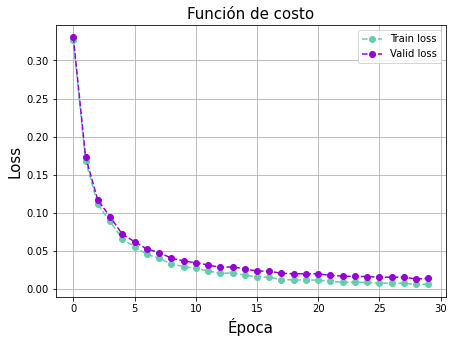

In [18]:
# Plot losses by epoch
plt.figure(figsize=(7,5))
plt.plot(diz_loss['train_loss_2'], linestyle='--', marker='o', label='Train loss', c='mediumaquamarine')
plt.plot(diz_loss['val_loss'], linestyle='--', marker='o', label='Valid loss', c='darkviolet')
plt.xlabel('Época',fontsize=15)
plt.ylabel('Loss',fontsize=15)
plt.title("Función de costo", fontsize=15)
plt.grid(True)
plt.legend()
plt.savefig('./Modelos_Fiteados/Imagenes/CLASIF/Nuevas_img/errores_rest5_T.png', format='png')
plt.show()

#### Veamos matriz de confusion y metricas

In [ ]:
model.load_state_dict(torch.load( "./Modelos_Fiteados/CLASIF/restringido_5_TODOS.pth" ))

In [ ]:
test_acc = 0

y_test=[]
y_pred=[]
label=[]
pred=[]

model.to(device)

with torch.no_grad():
    for x_batched, y_batched in test_loader:
        # Move data to device
        x_batched = x_batched.to(device)
        y_batched = y_batched.to(device)

        # forward the data
        out = model.forward(x_batched,"Test")

        y_test = (y_batched.detach().cpu().numpy())
        y_pred = (np.argmax(out.detach().cpu().numpy(), axis = 1))
        label.extend(y_test)
        pred.extend(y_pred)
        
        right = np.sum(y_pred == y_test)
        test_acc = test_acc + right

print(f"The obtained accuracy is {test_acc/len(RY_test)*100} %")

In [ ]:
def confussion_plot(real, prediction):
    categories = ['Clase 1', 'Clase 2', 'Clase 3', 'Clase 4', 'Clase 5']

    array = confusion_matrix(real, prediction,normalize="true")
    df_cm = pd.DataFrame(array, index = [i for i in categories], columns = [i for i in categories])
    
    fig = plt.figure(figsize=(8,7))
    sn.heatmap(df_cm, annot=True, fmt='.3f',  cmap='viridis')
    plt.ylabel("Label",fontsize=15)
    plt.xlabel("Prediccion",fontsize=15)
    plt.title("Matriz de Confusión",fontsize=15)
    plt.savefig('./Modelos_Fiteados/Imagenes/CLASIF/CM_5_Toodos.png', format='png')
    plt.show()

In [ ]:
confussion_plot(label, pred)

### Ahora vamos a ver que onda los numeros con los que no entreno. 

Para eso hago otro dataloader con el resto de los numeros y veo que tul

In [ ]:
#keep los...
keep2 = [0,1,2,5,6,8,9]

ls_nvo = [X_test[i] for i in range(len(X_test)) if y_test[i] in keep2]

RX_nvo = [0]*(20*len(ls_nvo))
RY_nvo = [0]*(20*len(ls_nvo))

for i in range(len(ls_nvo)):
    for j in range(20):
        ang = np.random.randint(-60,60)
        RX_nvo[i*20+j]=rotador(ls_nvo[i],ang)
        if -60<=ang<-36:
            RY_nvo[i*20+j]=0
        elif -36<=ang<-12:
            RY_nvo[i*20+j]=1
        elif -12<=ang<12:
            RY_nvo[i*20+j]=2
        elif 12<=ang<36:
            RY_nvo[i*20+j]=3
        else:
            RY_nvo[i*20+j]=4
            
            
to_tensor = torchvision.transforms.ToTensor()

tensor_RX_nvo = [to_tensor(RX_nvo[i]).unsqueeze(0) for i in range(len(RX_nvo))]
tensor_RX_nvo = torch.cat(tensor_RX_nvo)

tensor_RY_nvo = torch.Tensor(RY_nvo).long()

tensor_datanvo = TensorDataset(tensor_RX_nvo, tensor_RY_nvo)
nvo_loader = DataLoader(tensor_datanvo, batch_size=1)

In [ ]:
# Plot some samples
fig, axs = plt.subplots(5, 5, figsize=(8,8))
i = 0
for ax in axs.flatten():
    # random.choice allows to randomly sample from a list-like object 
    #(basically anything that can be accessed with an index, like our dataset)
    #img, label = random.choice(train_dataset)
    ax.imshow(np.array(RX_nvo[i]), cmap='gist_gray')
    ax.set_title(f'clase: {RY_nvo[i]}')
    ax.set_xticks([])
    ax.set_yticks([])
    i +=186
plt.savefig('./Modelos_Fiteados/Imagenes/ej_nvos.png', format='png')
plt.tight_layout()

In [ ]:
test_acc = 0

y_test=[]
y_pred=[]
label=[]
pred=[]

model.to(device)

with torch.no_grad():
    for x_batched, y_batched in nvo_loader:
        # Move data to device
        x_batched = x_batched.to(device)
        y_batched = y_batched.to(device)

        # forward the data
        out = model.forward(x_batched,"Test")

        y_test = (y_batched.detach().cpu().numpy())
        y_pred = (np.argmax(out.detach().cpu().numpy(), axis = 1))
        label.extend(y_test)
        pred.extend(y_pred)
        
        right = np.sum(y_pred == y_test)
        test_acc = test_acc + right

print(f"The obtained accuracy is {test_acc/len(RY_nvo)*100} %")

In [ ]:
confussion_plot(label, pred)